<a href="https://colab.research.google.com/github/mohamed-ben-lboukht/keystroke/blob/main/keystroke_freetext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Importations**

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

#**Chargement des données, extraction des caractéristiques et entraînement du modèle**

In [ ]:
df2 = pd.read_csv('GREYCNISLAB_NEW.csv')

# Step 2: Extract statistical features from timing columns
# Assuming timing columns start at index 6 and there are 67 timing columns
timing_columns = df.columns[6:73]  # Adjust indices if necessary

def compute_features(row):
    timings = row[timing_columns].values.astype(float)
    mean = np.mean(timings)
    std = np.std(timings)
    min_val = np.min(timings)
    max_val = np.max(timings)
    total = np.sum(timings)
    return [mean, std, min_val, max_val, total]

# Apply the function to each row
features = df.apply(compute_features, axis=1, result_type='expand')
features.columns = ['mean', 'std', 'min', 'max', 'total']

# Combine features with the target column (e.g., 'User_ID')
# Replace 'User_ID' with your actual target column name
data = pd.concat([df['User_ID'], features], axis=1)

# Step 3: Encode the labels to ensure they start from 0
le = LabelEncoder()
data['User_ID_encoded'] = le.fit_transform(data['User_ID'])
num_classes = len(le.classes_)

# Step 4: Prepare the data for training
X = data[['mean', 'std', 'min', 'max', 'total']].values
y = data['User_ID_encoded'].values  # Use encoded labels

# Split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Create PyTorch datasets and data loaders
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Step 6: Define the neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(5, 64)  # 5 input features
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)  # Output layer matches number of classes

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model
model = Net()

# Step 7: Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 8: Train the model
num_epochs = 20
for epoch in range(num_epochs):
    model.train()  # Set to training mode
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Clear gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

# Step 9: Evaluate the model on the test set
model.eval()  # Set to evaluation mode
correct = 0
total = 0
with torch.no_grad():  # No gradient computation
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Epoch 1/20, Loss: 4.6993
Epoch 2/20, Loss: 4.6866
Epoch 3/20, Loss: 4.7070
Epoch 4/20, Loss: 4.7058
Epoch 5/20, Loss: 4.7261
Epoch 6/20, Loss: 4.6922
Epoch 7/20, Loss: 4.7086
Epoch 8/20, Loss: 4.7095
Epoch 9/20, Loss: 4.7167
Epoch 10/20, Loss: 4.6992
Epoch 11/20, Loss: 4.7074
Epoch 12/20, Loss: 4.7044
Epoch 13/20, Loss: 4.6934
Epoch 14/20, Loss: 4.7044
Epoch 15/20, Loss: 4.7040
Epoch 16/20, Loss: 4.6877
Epoch 17/20, Loss: 4.6940
Epoch 18/20, Loss: 4.7130
Epoch 19/20, Loss: 4.6883
Epoch 20/20, Loss: 4.7021
Test Accuracy: 0.36%


#**Prédiction sur de nouvelles données**

In [ ]:
np.random.seed(42)  # For reproducibility
test_data = {
    f'time{i+1}': np.random.randint(100000, 2000000, 3) for i in range(67)  # 3 records, 67 timings each
}

# Modify records for diversity
df_test = pd.DataFrame(test_data)
df_test.iloc[0] = np.random.randint(100000, 500000, 67)  # Fast typing (Record 1)
df_test.iloc[1] = np.random.randint(1000000, 5000000, 67)  # Slow, variable typing (Record 2)
df_test.iloc[2] = np.random.randint(500000, 2500000, 67)  # Moderate typing (Record 3)

# Step 2: Extract statistical features
def compute_features_test(row):
    timings = row.values
    return pd.Series([timings.mean(), timings.std(), timings.min(), timings.max(), timings.sum()],
                     index=['mean', 'std', 'min', 'max', 'total'])

test_features = df_test.apply(compute_features_test, axis=1, result_type='expand')
test_features.columns = ['mean', 'std', 'min', 'max', 'total']

# Step 3: Load scalers and encoders
with open('scaler_X.pkl', 'rb') as f:
    scaler_X = pickle.load(f)
with open('scaler_age.pkl', 'rb') as f:
    scaler_age = pickle.load(f)
with open('le_gender.pkl', 'rb') as f:
    le_gender = pickle.load(f)
with open('le_handedness.pkl', 'rb') as f:
    le_handedness = pickle.load(f)
with open('le_class.pkl', 'rb') as f:
    le_class = pickle.load(f)

# Step 4: Scale test features
test_features_scaled = scaler_X.transform(test_features.values)
test_tensor = torch.tensor(test_features_scaled, dtype=torch.float32)

# Step 5: Define the model (must match training architecture)
class MultiOutputNet(nn.Module):
    def __init__(self):
        super(MultiOutputNet, self).__init__()
        self.shared = nn.Sequential(
            nn.Linear(5, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.age_head = nn.Sequential(
            nn.Linear(32, 1),
            nn.ReLU()
        )
        self.gender_head = nn.Linear(32, 2)
        self.handedness_head = nn.Linear(32, 2)
        self.class_head = nn.Linear(32, 2)

    def forward(self, x):
        x = self.shared(x)
        age = self.age_head(x)
        gender = self.gender_head(x)
        handedness = self.handedness_head(x)
        class_out = self.class_head(x)
        return age, gender, handedness, class_out

# Step 6: Load the trained model
model = MultiOutputNet()
model.load_state_dict(torch.load('multi_output_model.pth'))
model.eval()

# Step 7: Predict
with torch.no_grad():
    age_pred, gender_pred, handedness_pred, class_pred = model(test_tensor)
    age_pred_denorm = scaler_age.inverse_transform(age_pred.squeeze().numpy().reshape(-1, 1)).flatten()
    _, gender_pred = torch.max(gender_pred, 1)
    _, handedness_pred = torch.max(handedness_pred, 1)
    _, class_pred = torch.max(class_pred, 1)

    gender_pred = le_gender.inverse_transform(gender_pred.numpy())
    handedness_pred = le_handedness.inverse_transform(handedness_pred.numpy())
    class_pred = le_class.inverse_transform(class_pred.numpy())

# Step 8: Output predictions
print("Predictions for New Test Records:")
for i in range(len(age_pred)):
    print(f"Record {i+1}: Age={age_pred_denorm[i]:.1f}, Gender={gender_pred[i]}, "
          f"Handedness={handedness_pred[i]}, Class={class_pred[i]}")

Predictions for New Test Records:
Record 1: Age=32.7, Gender=M, Handedness=R, Class=2
Record 2: Age=32.8, Gender=M, Handedness=R, Class=1
Record 3: Age=32.7, Gender=M, Handedness=R, Class=2


#**Validation croisée et évaluation multi-tâches**

In [ ]:
# Step 1: Load and validate all five datasets
df1 = pd.read_csv('GREYCNISLAB_NEW1.csv')
df2 = pd.read_csv('GREYCNISLAB_NEW2.csv')
df3 = pd.read_csv('GREYCNISLAB_NEW3.csv')  # Your third dataset
df4 = pd.read_csv('GREYCNISLAB_NEW4.csv')  # Your fourth dataset
df5 = pd.read_csv('GREYCNISLAB_NEW.csv')  # Your fifth dataset
df = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)

# Check for invalid values
print("Checking for invalid values...")
print("NaN in timing columns:", df.iloc[:, 6:73].isna().sum().sum())
print("NaN in Age:", df['Age'].isna().sum())
print("NaN in Gender:", df['Gender'].isna().sum())
print("NaN in Handedness:", df['Handedness'].isna().sum())
print("NaN in Class:", df['Class'].isna().sum())

# Impute NaN in timing columns with column means
timing_columns = df.columns[6:73]
for col in timing_columns:
    df[col] = df[col].fillna(df[col].mean())

print("Rows after imputation:", len(df))

# Step 2: Validate categorical columns
print("\nUnique Gender values:", df['Gender'].unique())
print("Unique Handedness values:", df['Handedness'].unique())
print("Unique Class values:", df['Class'].unique())

# Step 3: Extract statistical features
def compute_features(row):
    timings = row[timing_columns].values.astype(float)
    if np.any(np.isnan(timings)) or np.any(np.isinf(timings)):
        return [0, 0, 0, 0, 0]
    return [np.mean(timings), np.std(timings) if np.std(timings) != 0 else 1e-6,
            np.min(timings), np.max(timings), np.sum(timings)]

features = df.apply(compute_features, axis=1, result_type='expand')
features.columns = ['mean', 'std', 'min', 'max', 'total']

# Custom normalization
class RobustScaler:
    def __init__(self):
        self.means_ = None
        self.stds_ = None

    def fit_transform(self, X):
        self.means_ = np.mean(X, axis=0)
        self.stds_ = np.std(X, axis=0)
        self.stds_[self.stds_ == 0] = 1e-6
        return (X - self.means_) / self.stds_

    def transform(self, X):
        return (X - self.means_) / self.stds_

    def inverse_transform(self, X):
        return X * self.stds_ + self.means_

scaler_X = RobustScaler()
scaler_age = RobustScaler()

X = scaler_X.fit_transform(features.values)
df['Age_normalized'] = scaler_age.fit_transform(df[['Age']].values)

# Encode categorical targets
le_gender = LabelEncoder()
le_handedness = LabelEncoder()
le_class = LabelEncoder()

df['Gender_encoded'] = le_gender.fit_transform(df['Gender'])
df['Handedness_encoded'] = le_handedness.fit_transform(df['Handedness'])
df['Class_encoded'] = le_class.fit_transform(df['Class'])

# Combine features and targets into 'data'
data = pd.concat([pd.DataFrame(X, columns=features.columns),
                  df[['Age_normalized', 'Gender_encoded', 'Handedness_encoded', 'Class_encoded']]],
                 axis=1)

# Verify columns
print("Columns in 'data':", data.columns.tolist())

# Step 4: Prepare data for cross-validation
X = data[['mean', 'std', 'min', 'max', 'total']].values
y_age = data['Age_normalized'].values
y_gender = data['Gender_encoded'].values
y_handedness = data['Handedness_encoded'].values
y_class = data['Class_encoded'].values

# Step 5: Define the enhanced model
class MultiOutputNet(nn.Module):
    def __init__(self):
        super(MultiOutputNet, self).__init__()
        self.shared = nn.Sequential(
            nn.Linear(5, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.age_head = nn.Sequential(
            nn.Linear(32, 1),
            nn.ReLU()
        )
        self.gender_head = nn.Linear(32, 2)
        self.handedness_head = nn.Linear(32, 2)
        self.class_head = nn.Linear(32, 2)

    def forward(self, x):
        x = self.shared(x)
        age = self.age_head(x)
        gender = self.gender_head(x)
        handedness = self.handedness_head(x)
        class_out = self.class_head(x)
        return age, gender, handedness, class_out

# Step 6: Perform 5-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
num_epochs = 50  # Increased epochs
batch_size = 32

age_errors = []
gender_accs = []
handedness_accs = []
class_accs = []

for fold, (train_idx, test_idx) in enumerate(kfold.split(X)):
    print(f'\nFold {fold + 1}/5')

    # Split data
    X_train, X_test = X[train_idx], X[test_idx]
    y_age_train, y_age_test = y_age[train_idx], y_age[test_idx]
    y_gender_train, y_gender_test = y_gender[train_idx], y_gender[test_idx]
    y_handedness_train, y_handedness_test = y_handedness[train_idx], y_handedness[test_idx]
    y_class_train, y_class_test = y_class[train_idx], y_class[test_idx]

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_age_train_tensor = torch.tensor(y_age_train, dtype=torch.float32)
    y_age_test_tensor = torch.tensor(y_age_test, dtype=torch.float32)
    y_gender_train_tensor = torch.tensor(y_gender_train, dtype=torch.long)
    y_gender_test_tensor = torch.tensor(y_gender_test, dtype=torch.long)
    y_handedness_train_tensor = torch.tensor(y_handedness_train, dtype=torch.long)
    y_handedness_test_tensor = torch.tensor(y_handedness_test, dtype=torch.long)
    y_class_train_tensor = torch.tensor(y_class_train, dtype=torch.long)
    y_class_test_tensor = torch.tensor(y_class_test, dtype=torch.long)

    # Create DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_age_train_tensor, y_gender_train_tensor,
                                  y_handedness_train_tensor, y_class_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_age_test_tensor, y_gender_test_tensor,
                                 y_handedness_test_tensor, y_class_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, loss, and optimizer
    model = MultiOutputNet()
    mse_loss = nn.MSELoss()
    ce_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)  # Increased learning rate

    # Train
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for inputs, age_labels, gender_labels, handedness_labels, class_labels in train_loader:
            optimizer.zero_grad()
            age_pred, gender_pred, handedness_pred, class_pred = model(inputs)

            loss_age = mse_loss(age_pred.squeeze(), age_labels)
            loss_gender = ce_loss(gender_pred, gender_labels)
            loss_handedness = ce_loss(handedness_pred, handedness_labels)
            loss_class = ce_loss(class_pred, class_labels)

            loss = 0.1 * loss_age + loss_gender + loss_handedness + loss_class
            if torch.isnan(loss):
                print(f"NaN loss detected at epoch {epoch+1}")
                break
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
        if epoch % 10 == 9:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / 100:.4f}')

    # Evaluate
    model.eval()
    total_age_error = 0
    correct_gender = correct_handedness = correct_class = 0
    total = 0
    with torch.no_grad():
        for inputs, age_labels, gender_labels, handedness_labels, class_labels in test_loader:
            age_pred, gender_pred, handedness_pred, class_pred = model(inputs)

            age_pred_denorm = scaler_age.inverse_transform(age_pred.squeeze().numpy().reshape(-1, 1))
            age_labels_denorm = scaler_age.inverse_transform(age_labels.numpy().reshape(-1, 1))
            total_age_error += np.mean(np.abs(age_pred_denorm - age_labels_denorm))

            _, gender_predicted = torch.max(gender_pred, 1)
            _, handedness_predicted = torch.max(handedness_pred, 1)
            _, class_predicted = torch.max(class_pred, 1)

            total += class_labels.size(0)
            correct_gender += (gender_predicted == gender_labels).sum().item()
            correct_handedness += (gender_predicted == gender_labels).sum().item()
            correct_class += (class_predicted == class_labels).sum().item()

    avg_age_error = total_age_error / len(test_loader)
    gender_acc = correct_gender / total
    handedness_acc = correct_handedness / total
    class_acc = correct_class / total

    print(f'Fold {fold + 1} Results:')
    print(f'Average Age Error: {avg_age_error:.2f} years')
    print(f'Gender Accuracy: {gender_acc * 100:.2f}%')
    print(f'Handedness Accuracy: {handedness_acc * 100:.2f}%')
    print(f'Class Accuracy: {class_acc * 100:.2f}%')

    age_errors.append(avg_age_error)
    gender_accs.append(gender_acc)
    handedness_accs.append(handedness_acc)
    class_accs.append(class_acc)

# Step 7: Report average performance
print('\nCross-Validation Results:')
print(f'Average Age Error: {np.mean(age_errors):.2f} ± {np.std(age_errors):.2f} years')
print(f'Average Gender Accuracy: {np.mean(gender_accs) * 100:.2f} ± {np.std(gender_accs) * 100:.2f}%')
print(f'Average Handedness Accuracy: {np.mean(handedness_accs) * 100:.2f} ± {np.std(handedness_accs) * 100:.2f}%')
print(f'Average Class Accuracy: {np.mean(class_accs) * 100:.2f} ± {np.std(class_accs) * 100:.2f}%')

Checking for invalid values...
NaN in timing columns: 6600
NaN in Age: 0
NaN in Gender: 0
NaN in Handedness: 0
NaN in Class: 0
Rows after imputation: 11000

Unique Gender values: ['F' 'M']
Unique Handedness values: ['L' 'R']
Unique Class values: [1 2]
Columns in 'data': ['mean', 'std', 'min', 'max', 'total', 'Age_normalized', 'Gender_encoded', 'Handedness_encoded', 'Class_encoded']

Fold 1/5
Epoch 10/50, Loss: 3.8732
Epoch 20/50, Loss: 3.8203
Epoch 30/50, Loss: 3.8031
Epoch 40/50, Loss: 3.7869
Epoch 50/50, Loss: 3.7717
Fold 1 Results:
Average Age Error: 7.42 years
Gender Accuracy: 70.77%
Handedness Accuracy: 70.77%
Class Accuracy: 83.86%

Fold 2/5
Epoch 10/50, Loss: 3.8726
Epoch 20/50, Loss: 3.8405
Epoch 30/50, Loss: 3.8153
Epoch 40/50, Loss: 3.7993
Epoch 50/50, Loss: 3.7806
Fold 2 Results:
Average Age Error: 7.25 years
Gender Accuracy: 71.77%
Handedness Accuracy: 71.77%
Class Accuracy: 84.45%

Fold 3/5
Epoch 10/50, Loss: 3.8693
Epoch 20/50, Loss: 3.8366
Epoch 30/50, Loss: 3.8050
Epoch

In [ ]:
# Chargement des datasets
df1 = pd.read_csv('GREYCNISLAB_NEW1.csv')
df2 = pd.read_csv('GREYCNISLAB_NEW2.csv')
df3 = pd.read_csv('GREYCNISLAB_NEW3.csv')
df4 = pd.read_csv('GREYCNISLAB_NEW4.csv')
df5 = pd.read_csv('GREYCNISLAB_NEW.csv')
df = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)

print("Datasets chargés avec succès.")

Datasets chargés avec succès.


Checking for invalid values...
NaN in timing columns: 6600
NaN in Age: 0
NaN in Gender: 0
NaN in Handedness: 0
NaN in Class: 0
Rows after imputation: 11000


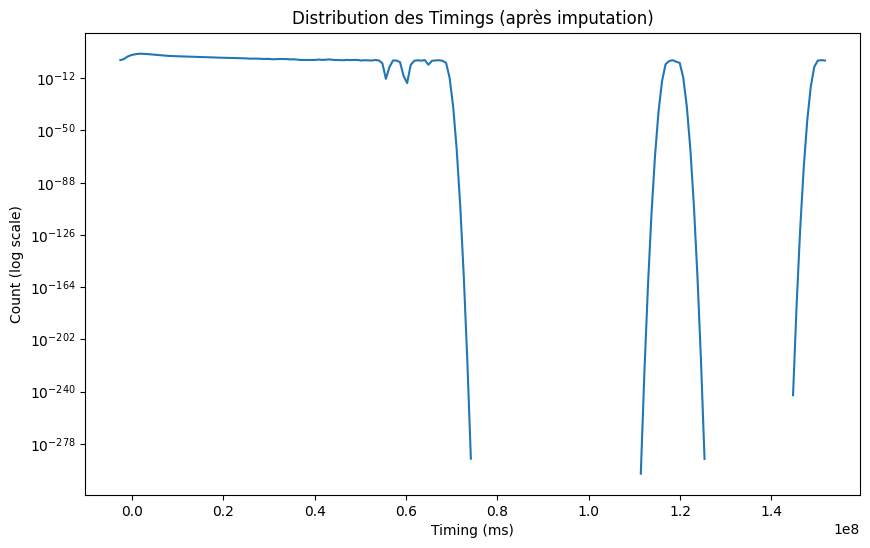

In [ ]:
# Vérification des valeurs invalides
print("Checking for invalid values...")
print("NaN in timing columns:", df.iloc[:, 6:73].isna().sum().sum())
print("NaN in Age:", df['Age'].isna().sum())
print("NaN in Gender:", df['Gender'].isna().sum())
print("NaN in Handedness:", df['Handedness'].isna().sum())
print("NaN in Class:", df['Class'].isna().sum())

# Imputation des NaN dans les colonnes de timings
timing_columns = df.columns[6:73]
for col in timing_columns:
    df[col] = df[col].fillna(df[col].mean())

print("Rows after imputation:", len(df))

# Visualisation : Histogramme des timings
plt.figure(figsize=(10, 6))
timings = df[timing_columns].values.flatten()
sns.histplot(timings, bins=50, kde=True, log_scale=(False, True))
plt.title("Distribution des Timings (après imputation)")
plt.xlabel("Timing (ms)")
plt.ylabel("Count (log scale)")
plt.show()


Unique Gender values: ['F' 'M']
Unique Handedness values: ['L' 'R']
Unique Class values: [1 2]

Class distribution:
 Class
1    0.5
2    0.5
Name: proportion, dtype: float64
Handedness distribution:
 Handedness
R    0.890909
L    0.109091
Name: proportion, dtype: float64
Gender distribution:
 Gender
M    0.709091
F    0.290909
Name: proportion, dtype: float64


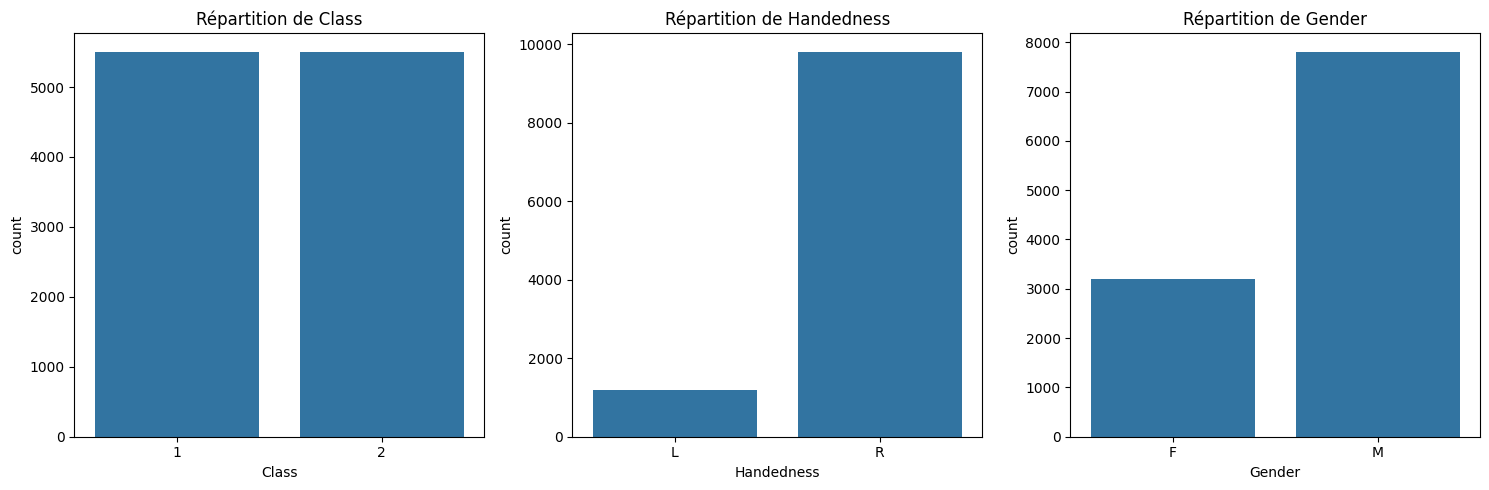

In [ ]:
# Validation des colonnes catégoriques
print("\nUnique Gender values:", df['Gender'].unique())
print("Unique Handedness values:", df['Handedness'].unique())
print("Unique Class values:", df['Class'].unique())

# Répartitions des classes
print("\nClass distribution:\n", df['Class'].value_counts(normalize=True))
print("Handedness distribution:\n", df['Handedness'].value_counts(normalize=True))
print("Gender distribution:\n", df['Gender'].value_counts(normalize=True))

# Visualisation : Barplots des répartitions
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.countplot(x='Class', data=df)
plt.title("Répartition de Class")
plt.subplot(1, 3, 2)
sns.countplot(x='Handedness', data=df)
plt.title("Répartition de Handedness")
plt.subplot(1, 3, 3)
sns.countplot(x='Gender', data=df)
plt.title("Répartition de Gender")
plt.tight_layout()
plt.show()

In [ ]:
# Fonction pour calculer les caractéristiques
def compute_features(row):
    timings = row[timing_columns].values.astype(float)
    if np.any(np.isnan(timings)) or np.any(np.isinf(timings)):
        return [0, 0, 0, 0, 0, 0, 0]
    return [np.mean(timings),
            np.std(timings) if np.std(timings) != 0 else 1e-6,
            np.min(timings),
            np.max(timings),
            np.sum(timings),
            np.median(timings),
            skew(timings)]

# Extraction des caractéristiques
features = df.apply(compute_features, axis=1, result_type='expand')
features.columns = ['mean', 'std', 'min', 'max', 'total', 'median', 'skew']

# Normalisation
class RobustScaler:
    def __init__(self):
        self.means_ = None
        self.stds_ = None

    def fit_transform(self, X):
        self.means_ = np.mean(X, axis=0)
        self.stds_ = np.std(X, axis=0)
        self.stds_[self.stds_ == 0] = 1e-6
        return (X - self.means_) / self.stds_

    def transform(self, X):
        return (X - self.means_) / self.stds_

    def inverse_transform(self, X):
        return X * self.stds_ + self.means_

scaler_X = RobustScaler()
scaler_age = RobustScaler()

X = scaler_X.fit_transform(features.values)
df['Age_normalized'] = scaler_age.fit_transform(df[['Age']].values)

# Encodage des cibles catégoriques
le_gender = LabelEncoder()
le_handedness = LabelEncoder()
le_class = LabelEncoder()

df['Gender_encoded'] = le_gender.fit_transform(df['Gender'])
df['Handedness_encoded'] = le_handedness.fit_transform(df['Handedness'])
df['Class_encoded'] = le_class.fit_transform(df['Class'])

# Combinaison des données
data = pd.concat([pd.DataFrame(X, columns=features.columns),
                  df[['Age_normalized', 'Gender_encoded', 'Handedness_encoded', 'Class_encoded']]],
                 axis=1)

print("Columns in 'data':", data.columns.tolist())

Columns in 'data': ['mean', 'std', 'min', 'max', 'total', 'median', 'skew', 'Age_normalized', 'Gender_encoded', 'Handedness_encoded', 'Class_encoded']


In [ ]:
# Préparation des données pour la validation croisée
X = data[['mean', 'std', 'min', 'max', 'total', 'median', 'skew']].values
y_age = data['Age_normalized'].values
y_gender = data['Gender_encoded'].values
y_handedness = data['Handedness_encoded'].values
y_class = data['Class_encoded'].values

# Définition du modèle
class MultiOutputNet(nn.Module):
    def __init__(self):
        super(MultiOutputNet, self).__init__()
        self.shared = nn.Sequential(
            nn.Linear(7, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.age_head = nn.Sequential(
            nn.Linear(32, 1),
            nn.ReLU()
        )
        self.gender_head = nn.Linear(32, 2)
        self.handedness_head = nn.Linear(32, 2)
        self.class_head = nn.Linear(32, 2)

    def forward(self, x):
        x = self.shared(x)
        age = self.age_head(x)
        gender = self.gender_head(x)
        handedness = self.handedness_head(x)
        class_out = self.class_head(x)
        return age, gender, handedness, class_out


Fold 1/5
Epoch 10/50, Loss: 386.9950
Epoch 20/50, Loss: 380.6331
Epoch 30/50, Loss: 378.0837
Epoch 40/50, Loss: 374.9184
Epoch 50/50, Loss: 372.0581


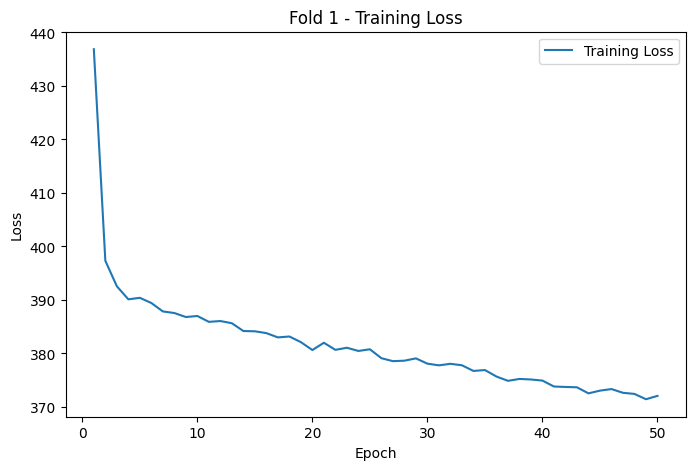

Fold 1 Results:
Average Age Error: 7.25 years
Gender Accuracy: 71.45%
Handedness Accuracy: 88.73%
Class Accuracy: 84.95%

Fold 2/5
Epoch 10/50, Loss: 385.3818
Epoch 20/50, Loss: 381.5641
Epoch 30/50, Loss: 377.8157
Epoch 40/50, Loss: 375.9859
Epoch 50/50, Loss: 371.1644


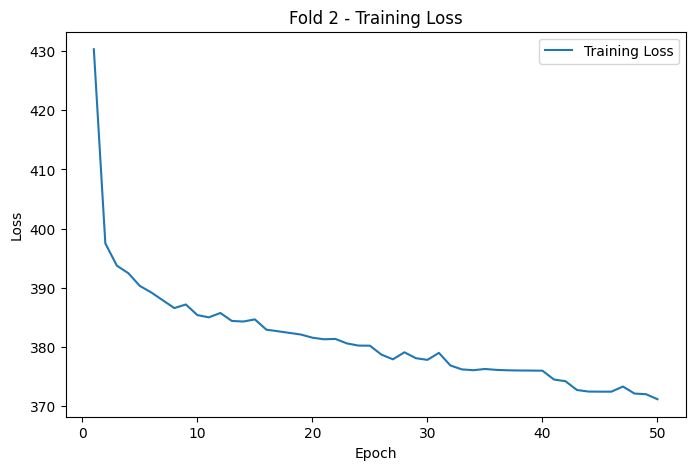

Fold 2 Results:
Average Age Error: 7.03 years
Gender Accuracy: 72.55%
Handedness Accuracy: 89.05%
Class Accuracy: 84.77%

Fold 3/5
Epoch 10/50, Loss: 385.4213
Epoch 20/50, Loss: 380.6949
Epoch 30/50, Loss: 375.8548
Epoch 40/50, Loss: 372.7021
Epoch 50/50, Loss: 369.8909


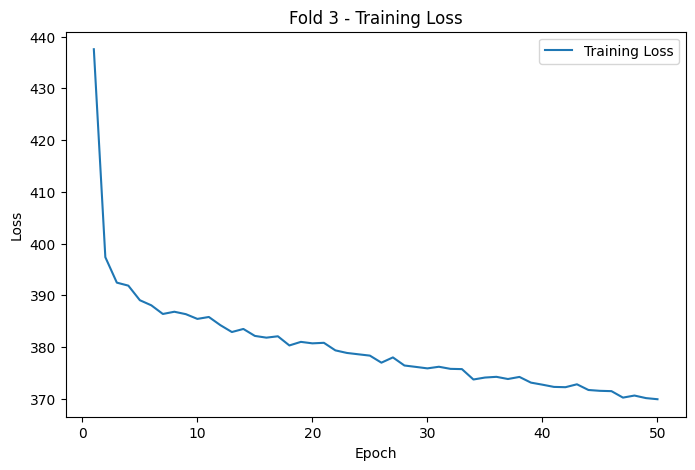

Fold 3 Results:
Average Age Error: 7.53 years
Gender Accuracy: 72.86%
Handedness Accuracy: 89.45%
Class Accuracy: 84.09%

Fold 4/5
Epoch 10/50, Loss: 390.3733
Epoch 20/50, Loss: 384.0497
Epoch 30/50, Loss: 380.0633
Epoch 40/50, Loss: 377.4144
Epoch 50/50, Loss: 375.5744


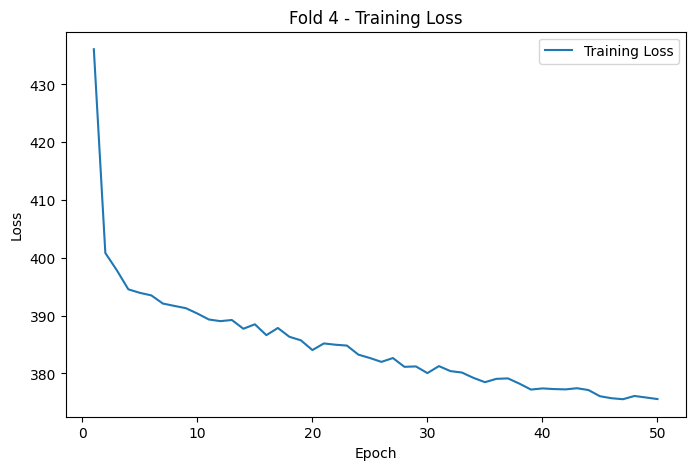

Fold 4 Results:
Average Age Error: 7.49 years
Gender Accuracy: 74.55%
Handedness Accuracy: 90.45%
Class Accuracy: 85.45%

Fold 5/5
Epoch 10/50, Loss: 381.7992
Epoch 20/50, Loss: 377.0620
Epoch 30/50, Loss: 373.5760
Epoch 40/50, Loss: 370.8376
Epoch 50/50, Loss: 367.8638


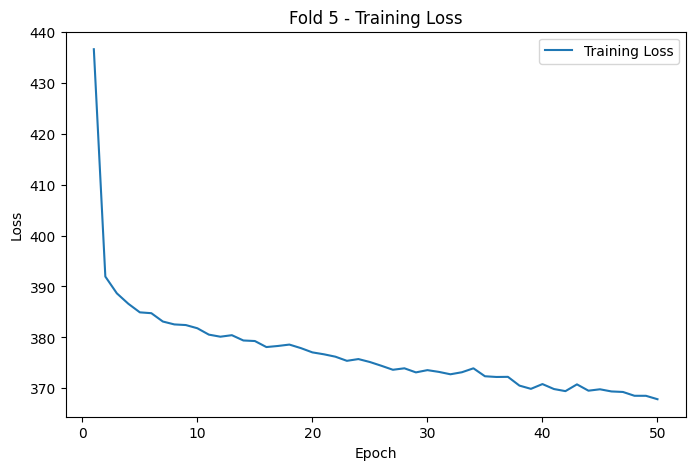

Fold 5 Results:
Average Age Error: 7.58 years
Gender Accuracy: 70.95%
Handedness Accuracy: 87.77%
Class Accuracy: 83.50%


In [ ]:
# Paramètres
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
num_epochs = 50
batch_size = 32

age_errors = []
gender_accs = []
handedness_accs = []
class_accs = []

# Validation croisée
for fold, (train_idx, test_idx) in enumerate(kfold.split(X)):
    print(f'\nFold {fold + 1}/5')

    # Séparation des données
    X_train, X_test = X[train_idx], X[test_idx]
    y_age_train, y_age_test = y_age[train_idx], y_age[test_idx]
    y_gender_train, y_gender_test = y_gender[train_idx], y_gender[test_idx]
    y_handedness_train, y_handedness_test = y_handedness[train_idx], y_handedness[test_idx]
    y_class_train, y_class_test = y_class[train_idx], y_class[test_idx]

    # Conversion en tenseurs
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_age_train_tensor = torch.tensor(y_age_train, dtype=torch.float32)
    y_age_test_tensor = torch.tensor(y_age_test, dtype=torch.float32)
    y_gender_train_tensor = torch.tensor(y_gender_train, dtype=torch.long)
    y_gender_test_tensor = torch.tensor(y_gender_test, dtype=torch.long)
    y_handedness_train_tensor = torch.tensor(y_handedness_train, dtype=torch.long)
    y_handedness_test_tensor = torch.tensor(y_handedness_test, dtype=torch.long)
    y_class_train_tensor = torch.tensor(y_class_train, dtype=torch.long)
    y_class_test_tensor = torch.tensor(y_class_test, dtype=torch.long)

    # DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_age_train_tensor, y_gender_train_tensor,
                                  y_handedness_train_tensor, y_class_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_age_test_tensor, y_gender_test_tensor,
                                 y_handedness_test_tensor, y_class_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialisation
    model = MultiOutputNet()
    mse_loss = nn.MSELoss()
    ce_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)

    # Entraînement avec suivi de la perte
    losses = []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for inputs, age_labels, gender_labels, handedness_labels, class_labels in train_loader:
            optimizer.zero_grad()
            age_pred, gender_pred, handedness_pred, class_pred = model(inputs)

            loss_age = mse_loss(age_pred.squeeze(), age_labels)
            loss_gender = ce_loss(gender_pred, gender_labels)
            loss_handedness = ce_loss(handedness_pred, handedness_labels)
            loss_class = ce_loss(class_pred, class_labels)

            loss = 0.1 * loss_age + loss_gender + loss_handedness + loss_class
            if torch.isnan(loss):
                print(f"NaN loss detected at epoch {epoch+1}")
                break
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
        losses.append(total_loss)
        if epoch % 10 == 9:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}')

    # Courbe de perte
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs+1), losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Fold {fold + 1} - Training Loss')
    plt.legend()
    plt.show()

    # Évaluation
    model.eval()
    total_age_error = 0
    correct_gender = correct_handedness = correct_class = 0
    total = 0
    with torch.no_grad():
        for inputs, age_labels, gender_labels, handedness_labels, class_labels in test_loader:
            age_pred, gender_pred, handedness_pred, class_pred = model(inputs)

            age_pred_denorm = scaler_age.inverse_transform(age_pred.squeeze().numpy().reshape(-1, 1))
            age_labels_denorm = scaler_age.inverse_transform(age_labels.numpy().reshape(-1, 1))
            total_age_error += np.mean(np.abs(age_pred_denorm - age_labels_denorm))

            _, gender_predicted = torch.max(gender_pred, 1)
            _, handedness_predicted = torch.max(handedness_pred, 1)
            _, class_predicted = torch.max(class_pred, 1)

            total += class_labels.size(0)
            correct_gender += (gender_predicted == gender_labels).sum().item()
            correct_handedness += (handedness_predicted == handedness_labels).sum().item()
            correct_class += (class_predicted == class_labels).sum().item()

    avg_age_error = total_age_error / len(test_loader)
    gender_acc = correct_gender / total
    handedness_acc = correct_handedness / total
    class_acc = correct_class / total

    print(f'Fold {fold + 1} Results:')
    print(f'Average Age Error: {avg_age_error:.2f} years')
    print(f'Gender Accuracy: {gender_acc * 100:.2f}%')
    print(f'Handedness Accuracy: {handedness_acc * 100:.2f}%')
    print(f'Class Accuracy: {class_acc * 100:.2f}%')

    age_errors.append(avg_age_error)
    gender_accs.append(gender_acc)
    handedness_accs.append(handedness_acc)
    class_accs.append(class_acc)


Cross-Validation Results:
Average Age Error: 7.38 ± 0.21 years
Average Gender Accuracy: 72.47 ± 1.25%
Average Handedness Accuracy: 89.09 ± 0.88%
Average Class Accuracy: 84.55 ± 0.68%


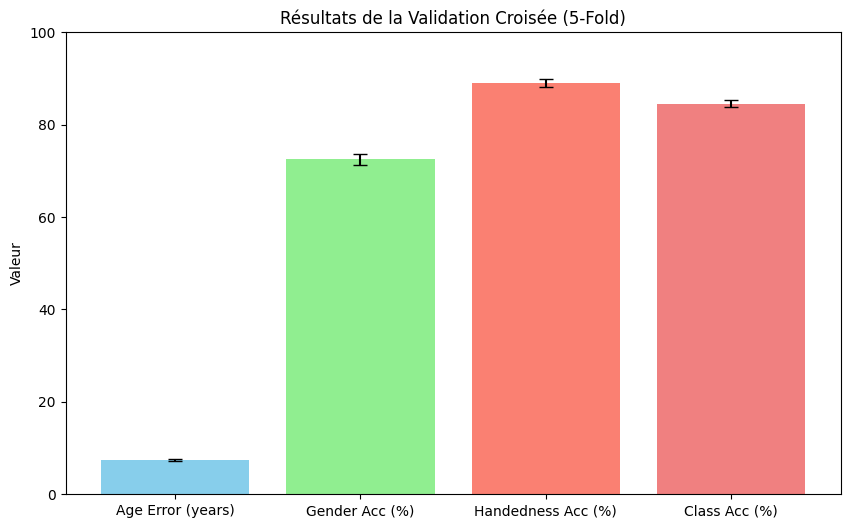

In [ ]:
# Résultats finaux
print('\nCross-Validation Results:')
print(f'Average Age Error: {np.mean(age_errors):.2f} ± {np.std(age_errors):.2f} years')
print(f'Average Gender Accuracy: {np.mean(gender_accs) * 100:.2f} ± {np.std(gender_accs) * 100:.2f}%')
print(f'Average Handedness Accuracy: {np.mean(handedness_accs) * 100:.2f} ± {np.std(handedness_accs) * 100:.2f}%')
print(f'Average Class Accuracy: {np.mean(class_accs) * 100:.2f} ± {np.std(class_accs) * 100:.2f}%')

# Visualisation des performances
metrics = ['Age Error (years)', 'Gender Acc (%)', 'Handedness Acc (%)', 'Class Acc (%)']
means = [np.mean(age_errors), np.mean(gender_accs) * 100, np.mean(handedness_accs) * 100, np.mean(class_accs) * 100]
stds = [np.std(age_errors), np.std(gender_accs) * 100, np.std(handedness_accs) * 100, np.std(class_accs) * 100]

plt.figure(figsize=(10, 6))
plt.bar(metrics, means, yerr=stds, capsize=5, color=['skyblue', 'lightgreen', 'salmon', 'lightcoral'])
plt.title('Résultats de la Validation Croisée (5-Fold)')
plt.ylabel('Valeur')
plt.ylim(0, 100)
plt.show()

***Dans cette section. Les étapes incluent le chargement des datasets, la vérification de leur structure, le prétraitement des timings (imputation des NaN et filtrage des outliers > 1M ms), et l'extraction de caractéristiques via des histogrammes à 20 bins. Des visualisations sont intégrées : histogrammes des timings, barplots des répartitions des classes (Gender, Handedness, Class), courbes de perte par époque, et un graphique final des performances de validation croisée. Le modèle neuronal prédit l’âge, le genre, la main dominante et la classe, avec une validation croisée entre bases pour évaluer la robustesse. Cette structure permet une exploration interactive et visuelle des données et des résultats***


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load all five datasets separately
datasets = [
    # Step 1: Load and validate all five datasets
    pd.read_csv('GREYCNISLAB_NEW1.csv'),
    pd.read_csv('GREYCNISLAB_NEW2.csv'),
    pd.read_csv('GREYCNISLAB_NEW3.csv'), # Your third dataset
    pd.read_csv('GREYCNISLAB_NEW4.csv'),  # Your fourth dataset
    pd.read_csv('GREYCNISLAB_NEW.csv')  # Your fifth dataset
]

In [ ]:
# Vérification de la structure
print("Verifying column structure...")
for i, df in enumerate(datasets):
    print(f"Dataset {i+1} - Number of columns: {len(df.columns)}")
    print(f"Dataset {i+1} - Column names: {list(df.columns)}")

# Identification des colonnes de timings communes
all_columns = [set(df.columns) for df in datasets]
common_columns = set.intersection(*all_columns)
timing_columns = [col for col in datasets[0].columns[6:] if col in common_columns]
print(f"\nCommon timing columns across all datasets: {timing_columns}")
print(f"Number of timing columns used: {len(timing_columns)}")

Verifying column structure...
Dataset 1 - Number of columns: 90
Dataset 1 - Column names: ['User_ID', 'Gender', 'Age', 'Handedness', 'Password', 'Class', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36', 'Unnamed: 37', 'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40', 'Unnamed: 41', 'Unnamed: 42', 'Unnamed: 43', 'Unnamed: 44', 'Unnamed: 45', 'Unnamed: 46', 'Unnamed: 47', 'Unnamed: 48', 'Unnamed: 49', 'Unnamed: 50', 'Unnamed: 51', 'Unnamed: 52', 'Unnamed: 53', 'Unnamed: 54', 'Unnamed: 55', 'Unnamed: 56', 'Unnamed: 57', 'Unnamed: 58', 'Unnamed: 59', 'Unnamed: 60', 'Unnamed: 61', 'Unnamed: 

Dataset 1 - NaN in timing columns: 0
Dataset 2 - NaN in timing columns: 0
Dataset 3 - NaN in timing columns: 0
Dataset 4 - NaN in timing columns: 0
Dataset 5 - NaN in timing columns: 0

Inspecting timing values after filtering...
Dataset 1 - Min timing: 0.00, Max timing: 1000000.00, Mean timing: 678710.39
Dataset 1 - Number of zero timings: 513
Dataset 2 - Min timing: 0.00, Max timing: 1000000.00, Mean timing: 622474.88
Dataset 2 - Number of zero timings: 323
Dataset 3 - Min timing: 0.00, Max timing: 1000000.00, Mean timing: 681358.24
Dataset 3 - Number of zero timings: 437
Dataset 4 - Min timing: 0.00, Max timing: 1000000.00, Mean timing: 699662.71
Dataset 4 - Number of zero timings: 184
Dataset 5 - Min timing: 0.00, Max timing: 1000000.00, Mean timing: 675315.38
Dataset 5 - Number of zero timings: 673


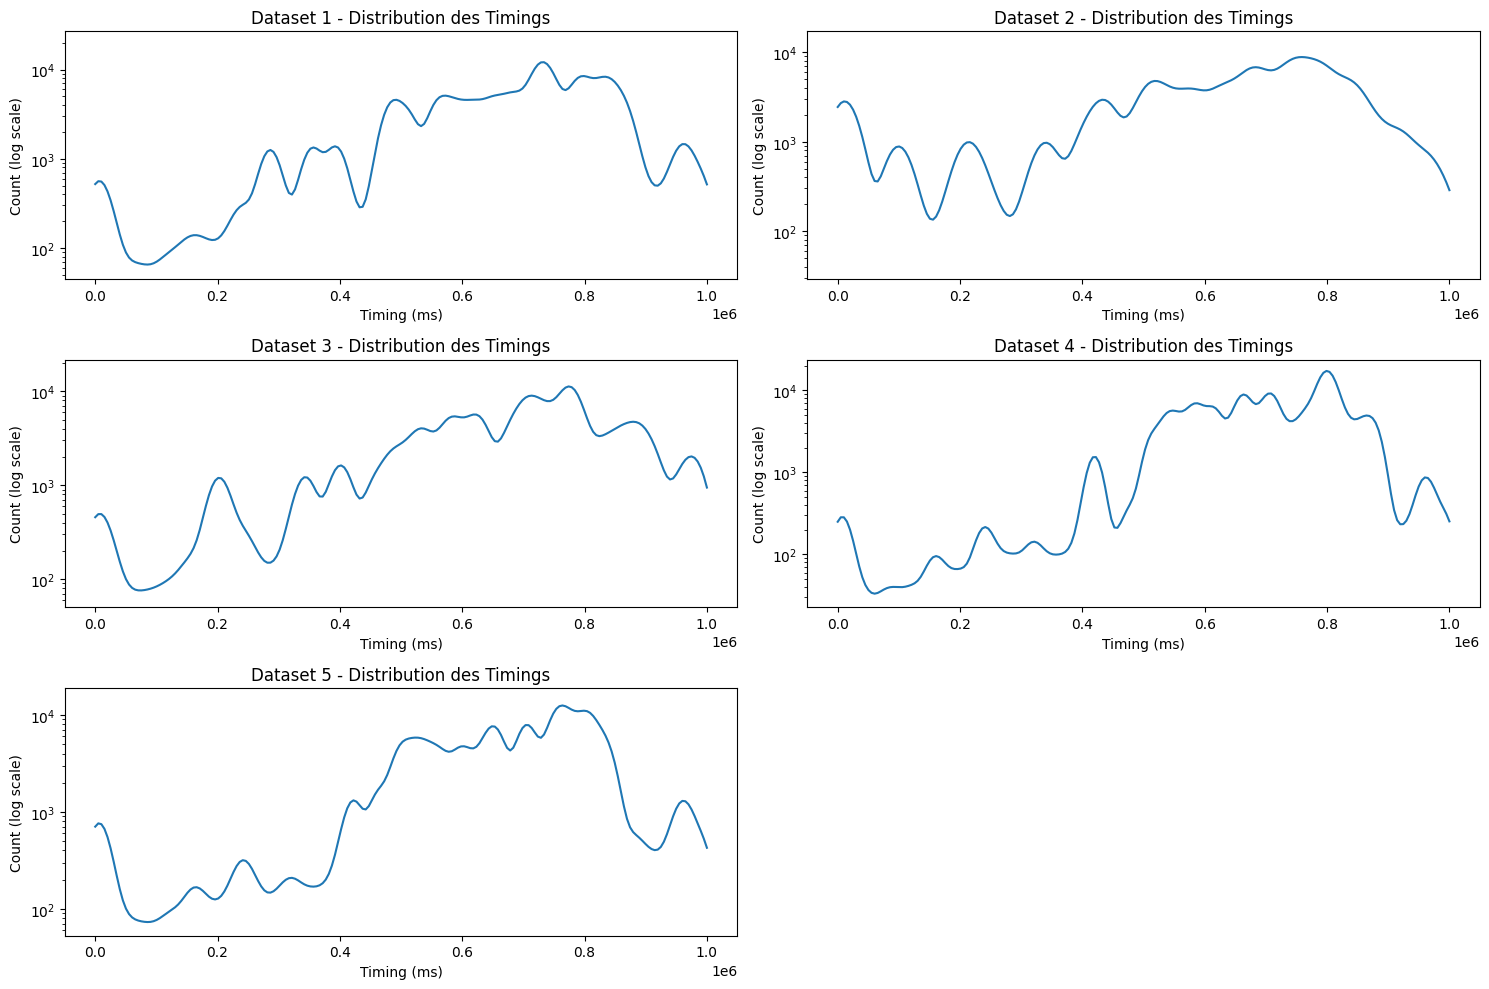

In [ ]:
# Prétraitement : Imputation et filtrage des outliers
for i, df in enumerate(datasets):
    print(f"Dataset {i+1} - NaN in timing columns: {df[timing_columns].isna().sum().sum()}")
    for col in timing_columns:
        df[col] = df[col].fillna(df[col].mean())
    # Filtrer les outliers (> 1M ms ou négatifs)
    df[timing_columns] = df[timing_columns].apply(lambda x: np.where((x < 0) | (x > 1000000), np.nan, x))
    for col in timing_columns:
        df[col] = df[col].fillna(df[col].mean())

# Inspection des timings après filtrage
print("\nInspecting timing values after filtering...")
for i, df in enumerate(datasets):
    timings = df[timing_columns].values.flatten()
    print(f"Dataset {i+1} - Min timing: {np.nanmin(timings):.2f}, Max timing: {np.nanmax(timings):.2f}, Mean timing: {np.nanmean(timings):.2f}")
    print(f"Dataset {i+1} - Number of zero timings: {np.sum(timings == 0)}")

# Visualisation : Histogramme des timings pour chaque dataset
plt.figure(figsize=(15, 10))
for i, df in enumerate(datasets):
    timings = df[timing_columns].values.flatten()
    plt.subplot(3, 2, i+1)
    sns.histplot(timings, bins=50, kde=True, log_scale=(False, True))
    plt.title(f"Dataset {i+1} - Distribution des Timings")
    plt.xlabel("Timing (ms)")
    plt.ylabel("Count (log scale)")
plt.tight_layout()
plt.show()

In [ ]:
# Fonction pour extraire les histogrammes
def compute_histogram_features(row, bins=20, min_range=0, max_range=1000):
    timings = row[timing_columns].values.astype(float)
    if np.any(np.isnan(timings)) or np.any(np.isinf(timings)) or np.nanmax(timings) == np.nanmin(timings):
        return np.zeros(bins)
    hist, _ = np.histogram(timings, bins=bins, range=(min_range, max_range))
    hist_sum = hist.sum()
    if hist_sum == 0:
        return np.zeros(bins)
    return hist / hist_sum

# Classe pour normalisation
class RobustScaler:
    def __init__(self):
        self.means_ = None
        self.stds_ = None

    def fit_transform(self, X):
        self.means_ = np.mean(X, axis=0)
        self.stds_ = np.std(X, axis=0)
        self.stds_[self.stds_ == 0] = 1e-6
        return (X - self.means_) / self.stds_

    def transform(self, X):
        return (X - self.means_) / self.stds_

    def inverse_transform(self, X):
        return X * self.stds_ + self.means_

# Déterminer la plage globale pour l’histogramme
all_timings = np.concatenate([df[timing_columns].values.flatten() for df in datasets])
min_range = max(0, np.nanmin(all_timings))
max_range = np.nanmax(all_timings) if np.nanmax(all_timings) > min_range else 1000
print(f"\nGlobal timing range for histogram: ({min_range:.2f}, {max_range:.2f})")

# Traitement des datasets
data_list = []
for df in datasets:
    features = df.apply(lambda row: compute_histogram_features(row, bins=20, min_range=min_range, max_range=max_range), axis=1, result_type='expand')
    features.columns = [f'bin_{i}' for i in range(20)]

    scaler_X = RobustScaler()
    X = scaler_X.fit_transform(features.values)

    scaler_age = RobustScaler()
    df['Age_normalized'] = scaler_age.fit_transform(df[['Age']].values)

    le_gender = LabelEncoder()
    le_handedness = LabelEncoder()
    le_class = LabelEncoder()

    df['Gender_encoded'] = le_gender.fit_transform(df['Gender'])
    df['Handedness_encoded'] = le_handedness.fit_transform(df['Handedness'])
    df['Class_encoded'] = le_class.fit_transform(df['Class'])

    data = pd.concat([pd.DataFrame(X, columns=features.columns),
                      df[['Age_normalized', 'Gender_encoded', 'Handedness_encoded', 'Class_encoded']]],
                     axis=1)
    data_list.append((data, scaler_X, scaler_age, le_gender, le_handedness, le_class))


Global timing range for histogram: (0.00, 1000000.00)


In [ ]:
# Définition du modèle (20 bins en entrée)
class MultiOutputNet(nn.Module):
    def __init__(self):
        super(MultiOutputNet, self).__init__()
        self.shared = nn.Sequential(
            nn.Linear(20, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.age_head = nn.Sequential(
            nn.Linear(32, 1),
            nn.ReLU()
        )
        self.gender_head = nn.Linear(32, 2)
        self.handedness_head = nn.Linear(32, 2)
        self.class_head = nn.Linear(32, 2)

    def forward(self, x):
        x = self.shared(x)
        age = self.age_head(x)
        gender = self.gender_head(x)
        handedness = self.handedness_head(x)
        class_out = self.class_head(x)
        return age, gender, handedness, class_out


Fold 1/5 (Testing on dataset 1)
Epoch 10/50, Loss: 385.4972
Epoch 20/50, Loss: 380.1606
Epoch 30/50, Loss: 373.8685
Epoch 40/50, Loss: 369.7743
Epoch 50/50, Loss: 366.3356


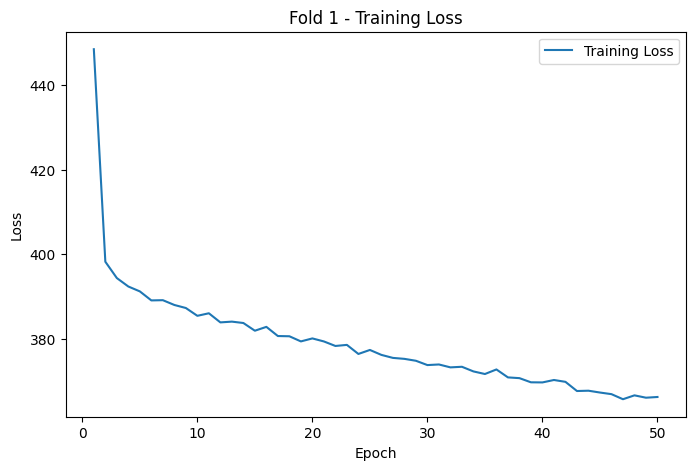

Fold 1 Results:
Average Age Error: 7.40 years
Gender Accuracy: 70.68%
Handedness Accuracy: 88.82%
Class Accuracy: 80.27%

Fold 2/5 (Testing on dataset 2)
Epoch 10/50, Loss: 391.9327
Epoch 20/50, Loss: 383.1460
Epoch 30/50, Loss: 377.4154
Epoch 40/50, Loss: 371.8365
Epoch 50/50, Loss: 368.7565


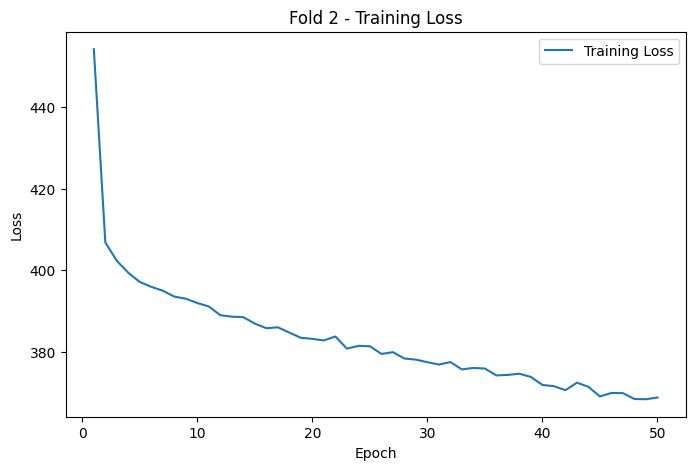

Fold 2 Results:
Average Age Error: 7.37 years
Gender Accuracy: 69.91%
Handedness Accuracy: 88.77%
Class Accuracy: 87.82%

Fold 3/5 (Testing on dataset 3)
Epoch 10/50, Loss: 361.1486
Epoch 20/50, Loss: 353.3467
Epoch 30/50, Loss: 347.7375
Epoch 40/50, Loss: 342.1502
Epoch 50/50, Loss: 337.4965


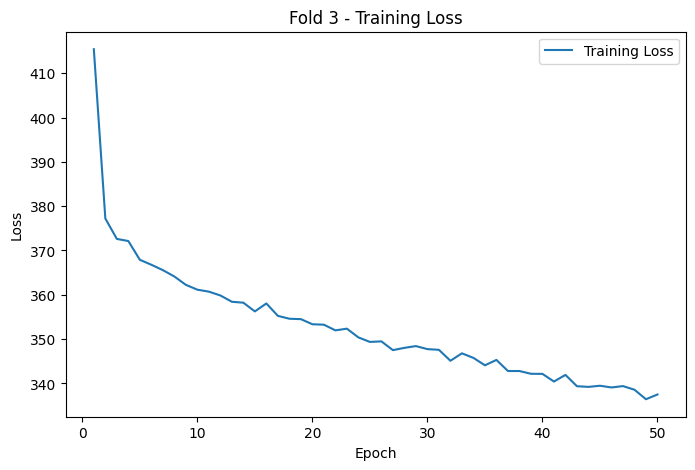

Fold 3 Results:
Average Age Error: 7.47 years
Gender Accuracy: 70.91%
Handedness Accuracy: 89.09%
Class Accuracy: 50.00%

Fold 4/5 (Testing on dataset 4)
Epoch 10/50, Loss: 390.6221
Epoch 20/50, Loss: 382.7495
Epoch 30/50, Loss: 376.1202
Epoch 40/50, Loss: 371.9242
Epoch 50/50, Loss: 367.1700


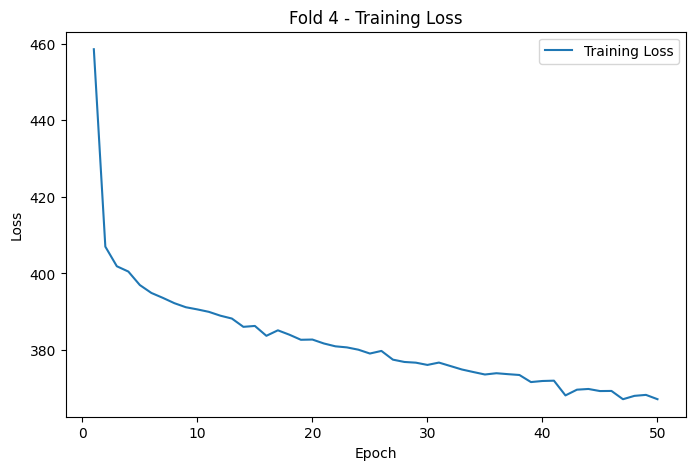

Fold 4 Results:
Average Age Error: 7.37 years
Gender Accuracy: 69.73%
Handedness Accuracy: 89.09%
Class Accuracy: 88.00%

Fold 5/5 (Testing on dataset 5)
Epoch 10/50, Loss: 390.8917
Epoch 20/50, Loss: 382.6564
Epoch 30/50, Loss: 376.7372
Epoch 40/50, Loss: 372.7322
Epoch 50/50, Loss: 367.5525


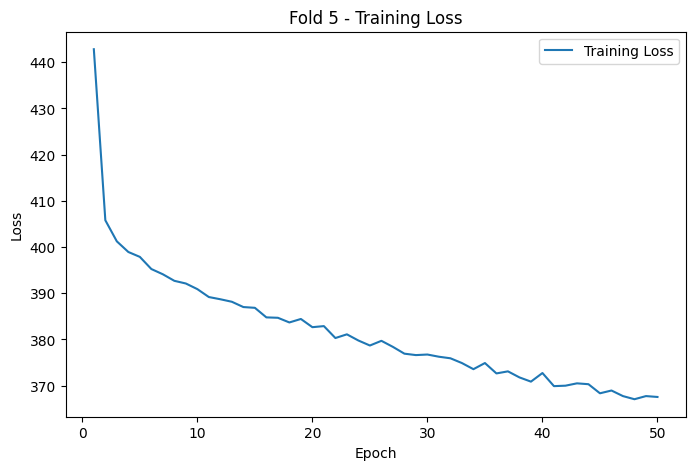

Fold 5 Results:
Average Age Error: 7.37 years
Gender Accuracy: 70.00%
Handedness Accuracy: 88.86%
Class Accuracy: 86.41%


In [ ]:
# Paramètres
num_epochs = 50
batch_size = 32

age_errors = []
gender_accs = []
handedness_accs = []
class_accs = []

# Validation croisée
for test_idx in range(5):
    print(f'\nFold {test_idx + 1}/5 (Testing on dataset {test_idx + 1})')

    train_dfs = [data_list[i][0] for i in range(5) if i != test_idx]
    train_data = pd.concat(train_dfs, ignore_index=True)
    test_data, test_scaler_X, test_scaler_age, test_le_gender, test_le_handedness, test_le_class = data_list[test_idx]

    X_train = train_data[[f'bin_{i}' for i in range(20)]].values
    y_age_train = train_data['Age_normalized'].values
    y_gender_train = train_data['Gender_encoded'].values
    y_handedness_train = train_data['Handedness_encoded'].values
    y_class_train = train_data['Class_encoded'].values

    X_test = test_data[[f'bin_{i}' for i in range(20)]].values
    y_age_test = test_data['Age_normalized'].values
    y_gender_test = test_data['Gender_encoded'].values
    y_handedness_test = test_data['Handedness_encoded'].values
    y_class_test = test_data['Class_encoded'].values

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_age_train_tensor = torch.tensor(y_age_train, dtype=torch.float32)
    y_age_test_tensor = torch.tensor(y_age_test, dtype=torch.float32)
    y_gender_train_tensor = torch.tensor(y_gender_train, dtype=torch.long)
    y_gender_test_tensor = torch.tensor(y_gender_test, dtype=torch.long)
    y_handedness_train_tensor = torch.tensor(y_handedness_train, dtype=torch.long)
    y_handedness_test_tensor = torch.tensor(y_handedness_test, dtype=torch.long)
    y_class_train_tensor = torch.tensor(y_class_train, dtype=torch.long)
    y_class_test_tensor = torch.tensor(y_class_test, dtype=torch.long)

    train_dataset = TensorDataset(X_train_tensor, y_age_train_tensor, y_gender_train_tensor,
                                  y_handedness_train_tensor, y_class_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_age_test_tensor, y_gender_test_tensor,
                                 y_handedness_test_tensor, y_class_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = MultiOutputNet()
    mse_loss = nn.MSELoss()
    ce_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)

    # Suivi de la perte
    losses = []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for inputs, age_labels, gender_labels, handedness_labels, class_labels in train_loader:
            optimizer.zero_grad()
            age_pred, gender_pred, handedness_pred, class_pred = model(inputs)

            loss_age = mse_loss(age_pred.squeeze(), age_labels)
            loss_gender = ce_loss(gender_pred, gender_labels)
            loss_handedness = ce_loss(handedness_pred, handedness_labels)
            loss_class = ce_loss(class_pred, class_labels)

            loss = 0.1 * loss_age + loss_gender + loss_handedness + loss_class
            if torch.isnan(loss):
                print(f"NaN loss detected at epoch {epoch+1}")
                break
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
        losses.append(total_loss)
        if epoch % 10 == 9:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}')

    # Courbe de perte
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs+1), losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Fold {test_idx + 1} - Training Loss')
    plt.legend()
    plt.show()

    # Évaluation
    model.eval()
    total_age_error = 0
    correct_gender = correct_handedness = correct_class = 0
    total = 0
    with torch.no_grad():
        for inputs, age_labels, gender_labels, handedness_labels, class_labels in test_loader:
            age_pred, gender_pred, handedness_pred, class_pred = model(inputs)

            age_pred_denorm = test_scaler_age.inverse_transform(age_pred.squeeze().numpy().reshape(-1, 1))
            age_labels_denorm = test_scaler_age.inverse_transform(age_labels.numpy().reshape(-1, 1))
            total_age_error += np.mean(np.abs(age_pred_denorm - age_labels_denorm))

            _, gender_predicted = torch.max(gender_pred, 1)
            _, handedness_predicted = torch.max(handedness_pred, 1)
            _, class_predicted = torch.max(class_pred, 1)

            total += class_labels.size(0)
            correct_gender += (gender_predicted == gender_labels).sum().item()
            correct_handedness += (handedness_predicted == handedness_labels).sum().item()
            correct_class += (class_predicted == class_labels).sum().item()

    avg_age_error = total_age_error / len(test_loader)
    gender_acc = correct_gender / total
    handedness_acc = correct_handedness / total
    class_acc = correct_class / total

    print(f'Fold {test_idx + 1} Results:')
    print(f'Average Age Error: {avg_age_error:.2f} years')
    print(f'Gender Accuracy: {gender_acc * 100:.2f}%')
    print(f'Handedness Accuracy: {handedness_acc * 100:.2f}%')
    print(f'Class Accuracy: {class_acc * 100:.2f}%')

    age_errors.append(avg_age_error)
    gender_accs.append(gender_acc)
    handedness_accs.append(handedness_acc)
    class_accs.append(class_acc)


Cross-Dataset Validation Results:
Average Age Error: 7.39 ± 0.04 years
Average Gender Accuracy: 70.25 ± 0.46%
Average Handedness Accuracy: 88.93 ± 0.14%
Average Class Accuracy: 78.50 ± 14.53%


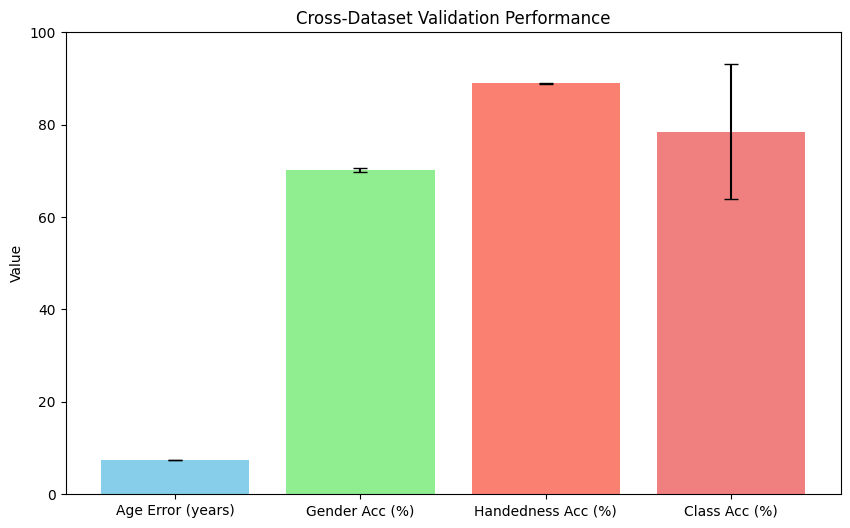

In [ ]:
# Résultats finaux
print('\nCross-Dataset Validation Results:')
print(f'Average Age Error: {np.mean(age_errors):.2f} ± {np.std(age_errors):.2f} years')
print(f'Average Gender Accuracy: {np.mean(gender_accs) * 100:.2f} ± {np.std(gender_accs) * 100:.2f}%')
print(f'Average Handedness Accuracy: {np.mean(handedness_accs) * 100:.2f} ± {np.std(handedness_accs) * 100:.2f}%')
print(f'Average Class Accuracy: {np.mean(class_accs) * 100:.2f} ± {np.std(class_accs) * 100:.2f}%')

# Visualisation des performances
metrics = ['Age Error (years)', 'Gender Acc (%)', 'Handedness Acc (%)', 'Class Acc (%)']
means = [np.mean(age_errors), np.mean(gender_accs) * 100, np.mean(handedness_accs) * 100, np.mean(class_accs) * 100]
stds = [np.std(age_errors), np.std(gender_accs) * 100, np.std(handedness_accs) * 100, np.std(class_accs) * 100]

plt.figure(figsize=(10, 6))
plt.bar(metrics, means, yerr=stds, capsize=5, color=['skyblue', 'lightgreen', 'salmon', 'lightcoral'])
plt.title('Cross-Dataset Validation Performance')
plt.ylabel('Value')
plt.ylim(0, 100)
plt.show()